### Fake News Classification

In [ ]:
## Load Pkgs
import numpy as np
import pandas as pd

# Load ML Pkgs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg
nlp = spacy.load('en')
nlp = spacy.load('en_core_web_sm')
# Creating a Spacy Parser
parser = English()

# Use the punctuations of string module
import re,string,unicodedata
punctuations = string.punctuation
from imblearn.over_sampling import SMOTE

# Plotly based imports for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 827.9 MB 1.1 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=103d505d520c504316bcec64589e4abea97af03a511d294c2b8a148da594761d
  Stored in directory: /tmp/pip-ephem-wheel-cache-jkvyuwhr/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
#Cargo las BBDD
from google.colab import files
true = pd.read_csv("True.csv")
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake = pd.read_csv("Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
#Observo las categorías
true.shape,fake.shape

((21417, 4), (23481, 4))

In [ ]:
# Muestra 75-25
fake = fake[0:23481]
true = true.sample(n=7827, random_state=42)

In [ ]:
#Asigno etiqueta a cada categoría
true['category'] = 1
fake['category'] = 0

df = pd.concat([true,fake])
df.head()

,title,text,subject,date,category
9946,Republican Cruz speaks highly of Rubio when as...,WASHINGTON (Reuters) - Republican White House ...,politicsNews,"April 14, 2016",1
8349,"Obama to meet Philippines' Duterte, broach hum...",WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"August 29, 2016",1
1644,Twitter to meet Congressional panel probing 20...,(Reuters) - Twitter Inc representatives will m...,politicsNews,"September 21, 2017",1
3752,U.S. Senate Intelligence committee wants more ...,WASHINGTON (Reuters) - The U.S. Senate Intelli...,politicsNews,"May 17, 2017",1
8862,U.S. attorney general to testify before House ...,(Reuters) - U.S. Attorney General Loretta Lync...,politicsNews,"July 6, 2016",1


In [ ]:
#Data Frame final
df.shape

(31308, 5)

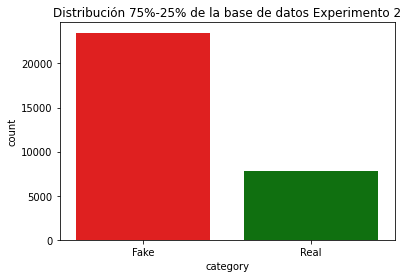

In [ ]:
#Grafico para ver la distribución
plt.figure(figsize=(6,4))
ax = sns.countplot(x="category", data=df)
plt.title('Distribución 75%-25% de la base de datos Experimento 2') 
ax.set_xticklabels(['Fake','Real'], rotation=0)
color = ["Red", "Green"] 
sns.set_palette(color)
plt.show()

In [ ]:
df.describe(include="object")

,title,text,subject,date
count,31308,31308,31308,31308
unique,25643,25242,8,2360
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"November 30, 2017"
freq,6,627,9050,60


In [ ]:
#Eliminación de caracteres especiales y puntuación
df['text'] = df['text'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x))

In [ ]:
contractions = {
"aight": "alright","ain't": "am not","amn't": "am not","aren't": "are not",
"can't": "can not","cause": "because","could've": "could have",
"couldn't": "could not","couldn't've": "could not have","daren't": "dare not",
"daren't": "dared not","daresn't": "dare not","dasn't": "dare not",
"didn't": "did not","doesn't": "does not","don't": "do not","don't": "does not",
"d'ye": "do you","d'ye": "did you","e'er": "ever","everybody's": "everybody is",
"everyone's": "everyone is","finna": "fixing to","finna": "going to",
"g'day": "good day","gimme": "give me","giv'n": "given","gonna": "going to",
"gon't": "go not","gotta": "got to","hadn't": "had not","had've": "had have",
"hasn't": "has not","haven't": "have not","he'd": "he had","he'd": "he would",
"he'dn't've'd": "he would not have had","he'll": "he shall",
"he'll": "he will","he's": "he has","he's": "he is","he've": "he have",
"how'd": "how did","how'd": "how would","howdy": "how do you do",
"howdy": "how do you fare","how'll": "how will","how're": "how are",
"I'll": "I shall","I'll": "I will","I'm": "I am","I'm'a": "I am about to",
"I'm'o": "I am going to","innit": "is it not","I've": "I have",
"isn't": "is not","it'd": "it would","it'll": "it shall","it'll": "it will",
"it's": "it has","it's": "it is","let's": "let us","ma'am": "madam",
"mayn't": "may not","may've": "may have","methinks": "me thinks",
"mightn't": "might not","might've": "might have","mustn't": "must not",
"mustn't've": "must not have","must've": "must have","needn't": "need not",
"ne'er": "never","o'clock": "of the clock","o'er": "over","ol'": "old",
"oughtn't": "ought not","'s": "is, has, does, or us","shalln't": "shall not",
"shan't": "shall not","she'd": "she had","she'd": "she would",
"she'll": "she shall","she'll": "she will","she's": "she has","she's": "she is",
"should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","somebody's": "somebody has",
"somebody's": "somebody is","someone's": "someone has",
"someone's": "someone is","something's": "something has",
"something's": "something is","so're": "so are","that'll": "that shall",
"that'll": "that will","that're": "that are","that's": "that has",
"that's": "that is","that'd": "that would","that'd": "that had",
"there'd": "there had","there'd": "there would","there'll": "there shall",
"there'll": "there will","there're": "there are","there's": "there has",
"there's": "there is","these're": "these are","these've": "these have",
"they'd": "they had","they'd": "they would","they'll": "they shall",
"they'll": "they will","they're": "they are","they're": "they were",
"they've": "they have","this's": "this has","this's": "this is",
"those're": "those are","those've": "those have","'tis": "it is",
"to've": "to have","'twas": "it was","wanna": "want to","wasn't": "was not",
"we'd": "we had","we'd": "we would","we'd": "we did","we'll": "we shall",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not",
"what'd": "what did","what'll": "what shall","what'll": "what will",
"what're": "what are","what're": "what were","what's": "what has",
"what's": "what is","what's": "what does","what've": "what have",
"when's": "when has","when's": "when is","where'd": "where did",
"where'll": "where shall","where'll": "where will","where're": "where are",
"where's": "where has","where's": "where is","where's": "where does",
"where've": "where have","which'd": "which had","which'd": "which would",
"which'll": "which shall","which'll": "which will","which're": "which are",
"which's": "which has","which's": "which is","which've": "which have",
"who'd": "who would","who'd": "who had","who'd": "who did",
"who'd've": "who would have","who'll": "who shall","who'll": "who will",
"who're": "who are","who's": "who has","who's": "who is",
"who's": "who does","who've": "who have","why'd": "why did",
"why're": "why are","why's": "why has","why's": "why is","why's": "why does",
"won't": "will not","would've": "would have","wouldn't": "would not",
"wouldn't've": "would not have","y'all": "you all",
"y'all'd've": "you all would have",
"y'all'dn't've'd": "you all would not have had","y'all're": "you all are",
"you'd": "you had","you'd": "you would","you'll": "you shall",
"you'll": "you will","you're": "you are","you're": "you are",
"you've": "you have"," u ": "you"," ur ": "your"," n ": "and"
}

In [ ]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

In [ ]:
# Construyo la lista de stopwords para filtrar
stopwords = list(STOP_WORDS)

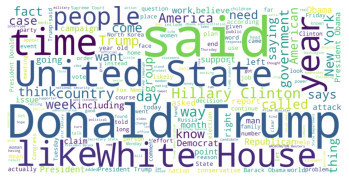

In [ ]:
#Word Cloud para todos los datos
wc = WordCloud(width = 4000, height = 2000, background_color= "white", stopwords = stopwords).generate(" ".join(df.text))
plt.imshow(wc)
plt.axis('off')
plt.show()

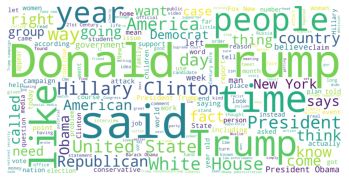

In [ ]:
#Word Cloud for Fake News
wc = WordCloud(width = 4000, height = 2000, background_color= "white", stopwords = stopwords).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc)
plt.axis('off')
plt.show()

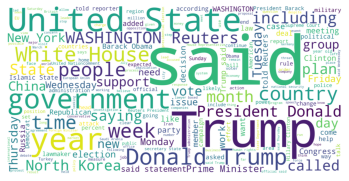

In [ ]:
#Word Cloud for True News
wc = WordCloud(width = 4000, height = 2000, background_color= "white", stopwords = stopwords).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
##Extracción de características
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [ ]:
#Transformador personalizado usando spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

In [ ]:
# Función básica para limpiar el texto
def clean_text(text):     
    return text.strip().lower()

In [ ]:
# Vectorización 
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
classifier = SVC() #por defecto el rbf= radial


In [ ]:
###### División de conjuntos de datos
# Características y etiquetas
x = df['text']
ylabels = df['category']
x_train, x_test, y_train, y_test = train_test_split(x, ylabels, test_size=0.2, random_state=42)
#####
x_train_vector = vectorizer.fit_transform(x_train)
x_test_vector = vectorizer.transform(x_test)

In [ ]:
x_train

7190     Democratic Presidential hopeful Bernie Sanders...
18919    Convicted  Palestinian  terrorist and leader o...
2154     WASHINGTON Reuters - Mexicos economy minister ...
15863    KUALA LUMPUR Reuters - A Malaysian state s roy...
10608    WASHINGTON Reuters - As the Senates top Republ...
                               ...                        
21975     LONG SHADOW The wake of the recent mass trage...
2009     WASHINGTON Reuters - Special Counsel Robert Mu...
1052     WASHINGTON Reuters - The US Supreme Court on T...
7968     Anyone who has read the Bible knows that that ...
15827    Yep Hillary s now a champion of lesbians and g...
Name: text, Length: 25046, dtype: object

In [ ]:
x_train.shape

(25046,)

In [ ]:
# Cree la canalización para limpiar, tokenizar, vectorizar y clasifica
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

In [ ]:
#Ajustar los datos
pipe.fit(x_train, y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7ff8e035c910>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7ff9327eb170>)),
                ('classifier', SVC())])

In [ ]:
x_test.shape

(6262,)

In [ ]:
x_test.values[1]

'Alabama is a notoriously deep red state It s a place where Democrats always think that we have zero chances of winning   especially in statewide federal elections However that is just what happened on Tuesday night in the Special Election to replace Senator Jeff Sessions Doug Jones the Democratic Senate candidate who is known in the state for prosecuting the Ku Klux Klan members who bombed a church during the Civil Rights Movement and killed four little African American girls will be the next Senator from Alabama CNN has just called the race as there seems no more GOP-leaning counties out thereTo contrast Roy Moore had been twice removed from the Alabama Supreme Court as Chief Justice for violating the law and was also credibly accused of being a sexual predator toward teen girls Despite all of that though the race was a nail biter because Moore has a long history and a deep base in Alabama Of course decent people   including Republicans   were horrified at the idea of a man like Roy 

In [ ]:
# Predecir con un conjunto de datos de prueba
sample_prediction = pipe.predict(x_test)

In [ ]:
sample_prediction 

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
print("Puntaje de precisión:",pipe.score(x_test, y_test))

Puntaje de precisión: 0.991216863621846


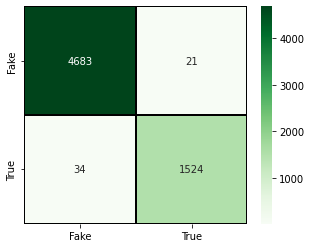

In [ ]:
pred_y = pipe.predict(x_test)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_y),cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True']);

### Algoritmos a evaluar

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train_vector, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Support Vector Machines (SVM)
svc = SVC(kernel='linear', random_state = 42)
svc.fit(x_train_vector, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
# Gradiente Boosting 
gbrt = GradientBoostingClassifier(random_state = 42)
gbrt.fit(x_train_vector, y_train)


GradientBoostingClassifier(random_state=42)

In [ ]:
# Evaluación de los modelos
# Puntaje de precisión
print("Puntaje de precisión Random Forest:" , rf.score(x_test_vector, y_test))
print("Puntaje de precisión SVC:" ,svc.score(x_test_vector, y_test))
print("Puntaje de precisión Gradient Boosting",gbrt.score(x_test_vector, y_test))

Puntaje de precisión Random Forest: 0.9899393165122964
Puntaje de precisión SVC: 0.9960076652826573
Puntaje de precisión Gradient Boosting 0.993452571063558


In [ ]:
# Matriz confusión  Random forest
# Una matriz de confusión es una tabla con dos filas y dos columnas que informa el número de falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos
conf_mat = confusion_matrix(y_test, rf.predict(x_test_vector), labels=[1, 0])
conf_mat

array([[1506,   52],
       [  11, 4693]])

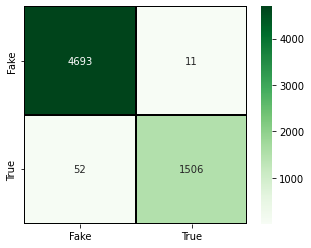

In [ ]:
pred_y_rf = rf.predict(x_test_vector)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_y_rf),cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True']);

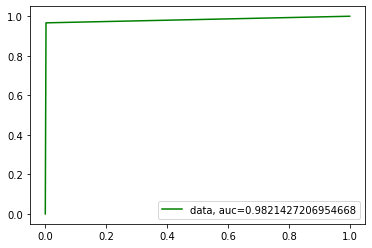

In [ ]:
#Curva de ROC Características Operativa del receptor Random Forest
y_pred_proba_rf = rf.predict(x_test_vector)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr,tpr,label="data, auc="+str(auc), color = ('green'))
plt.legend(loc=4)
plt.show()

In [ ]:
# Reporte de clasificación Random Forest
print(classification_report(y_test, y_pred_proba_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4704
           1       0.99      0.97      0.98      1558

    accuracy                           0.99      6262
   macro avg       0.99      0.98      0.99      6262
weighted avg       0.99      0.99      0.99      6262



In [ ]:
# Suport Vector Classification
# Matriz de Confusión SVC
conf_mat = confusion_matrix(y_test, svc.predict(x_test_vector), labels=[1, 0])
conf_mat

array([[1547,   11],
       [  14, 4690]])

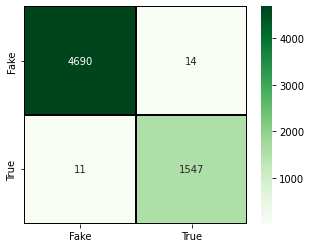

In [ ]:
pred_y_svm = svc.predict(x_test_vector)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_y_svm),cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True']);

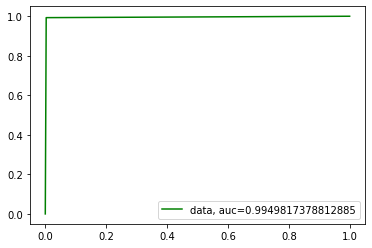

In [ ]:
#Curva de ROC Características Operativa del receptor SVC
y_pred_proba_svm = svc.predict(x_test_vector)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_svm)
auc = metrics.roc_auc_score(y_test, y_pred_proba_svm)
plt.plot(fpr,tpr,label="data, auc="+str(auc), color=('green'))
plt.legend(loc=4)
plt.show()

In [ ]:
# Reporte de clasificación SVC
print(classification_report(y_test, y_pred_proba_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4704
           1       0.99      0.99      0.99      1558

    accuracy                           1.00      6262
   macro avg       0.99      0.99      0.99      6262
weighted avg       1.00      1.00      1.00      6262



In [ ]:
##Gradient boosting
# Matriz de Confusión Gb
conf_mat = confusion_matrix(y_test, gbrt.predict(x_test_vector), labels=[1, 0])
conf_mat

array([[1555,    3],
       [  38, 4666]])

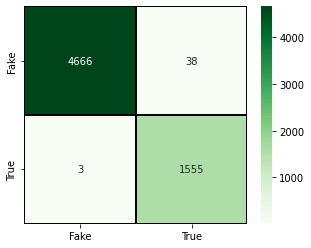

In [ ]:
pred_y_gbrt = gbrt.predict(x_test_vector)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_y_gbrt),cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True']);

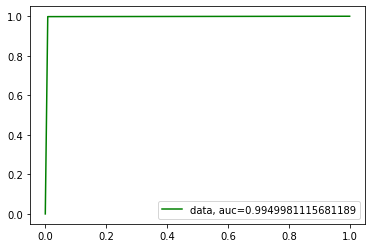

In [ ]:
#Curva de ROC Características Operativa del receptor Gb
y_pred_proba_gbrt = gbrt.predict(x_test_vector)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_gbrt)
auc = metrics.roc_auc_score(y_test, y_pred_proba_gbrt)
plt.plot(fpr,tpr,label="data, auc="+str(auc), color=('green'))
plt.legend(loc=4)
plt.show()

In [ ]:
# Reporte de clasificación Gb
print(classification_report(y_test, y_pred_proba_gbrt))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4704
           1       0.98      1.00      0.99      1558

    accuracy                           0.99      6262
   macro avg       0.99      0.99      0.99      6262
weighted avg       0.99      0.99      0.99      6262

